In [1]:
#!/usr/bin/env python
%matplotlib inline  

#ipython magic to make ampmodule autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import scipy.stats as st 
import sklearn.linear_model as slm 
from pyDOE import *
import ray

#pull in the classes to do the sims!
import AMPmodule

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

trialcolz=['teal','tan']

short_outz_labels=['PE','mean VL1','std dev VL1','mean IC50','std dev IC50']
long_outz_labels=['prevention efficacy (%)',
                  'mean VL1 log10(copies/mL)',
                  'std dev VL1 log10(copies/mL)',
                  'mean IC50 log10($\mu$g/mL)',
                  'std dev IC50 log10($\mu$g/mL)']

short_varz_labels=[r'$\log_{10}\phi$',r'$f$',r'$\log_{10}x_{50}$',r'$A_0$']
long_varz_labels=[r'potency reduction factor, $\log_{10}\phi$',
                  r'resistant fraction, $f$',
                  r'maximum IC50 $\log_{10}x_{50}$',
                  r'initial number infected cells $A_0$']

#standardize limits/ticks
ytickz=[[0,0.25,0.5,0.75,1],
       [0,1,2,3,4,5,6,7],
       [1,2,3],
       [-1,0,1,2],
       [0,1,2]]

xtickz=[[0,1,2,3],
       [0,0.2,0.4,0.6,0.8,1],
       [2,3,4],
       [0,5,10,15,20]]

In [2]:
#function to analyze output from a trial simultaion
def analyze_out(trial_list,tr_ctl):
    nts=len(trial_list)
    PE=np.zeros([nts])
    fpvls_avg=np.zeros([nts]); fpvls_std=np.zeros([nts]);
    IC50s_avg=np.zeros([nts]); IC50s_std=np.zeros([nts]);

    for it in range(nts):
        tr=trial_list[it]
        fpvls=np.log10(tr.fp_vs[tr.fp_vs>0])
        fpis=1+np.floor(tr.fp_ts[tr.fp_ts>0]/7/4)%2 #first positive indicies
        fpts=tr.fp_ts[tr.fp_vs>0]

        #rescale the IC50 so it matches what will be measured in vitro
        IC50s=np.log10(tr.ic50s[tr.fp_vs>0]/tr.iv_phi)
        IC50s[IC50s>np.log10(50)]=np.log10(50)

        #now trial summary outcomes
        PE[it]=1-sum(tr.fp_vs>0)/np.sum(tr_ctl.brks>0)

        fpvls_avg[it]=np.nanmean(fpvls)
        fpvls_std[it]=np.nanstd(fpvls)

        IC50s_avg[it]=np.nanmean(IC50s)
        IC50s_std[it]=np.nanstd(IC50s)

    outcomes=np.array([PE,fpvls_avg,fpvls_std,IC50s_avg,IC50s_std])

    return outcomes

In [ ]:
#local sensitivity analyses for potency reduction factor

#pick a single variable to do local sensitivity analysis
v=0 #0=iv, 1=rf, 2=mx, 3=A0

nts=15 #number of trials
Nps=500 #number of functional exposures per trial

#first, control trial -- time it so you can estimate, upper bound is nts*ctl_time
%time tr_ctl=AMPmodule.trial(name='ctl', nps=Nps, tF=560, dose=0, clade='bimodal', rfrac=0.1, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)

iv=np.logspace(0,3,nts) #potency factor
rf=np.linspace(0.10,1,nts) #resistant fraction, never less than 10%
mx=50+np.logspace(0,4,nts) #maximum IC50
A0=np.arange(1,nts*3,3) #initial number of infected cells

#pick a dose
D=[10,30]

varz=np.array([iv,rf,mx,A0]) #make array of variable values

#set all non-chosen values to initial val
for i in range(len(varz)):
    if i!=v:
        varz[i,:]=varz[i,0]

list_tr_local=[[],[]]; counter=0
for it in range(nts):
    for iid in range(len(D)):
        list_tr_local[iid].append(AMPmodule.trial(name='D_'+str(D[iid])+str(counter), nps=Nps, tF=560, 
                           dose=D[iid], clade='bimodal', 
                           rfrac=varz[1,it], A0=varz[3,it], iv_phi=varz[0,it], maxIC50=varz[2,it], 
                               v_flg=False, keep_flg=0))
    counter+=1
    print(counter)


In [ ]:
#plot local analysis
pltvarz=np.array([np.log10(iv),rf,np.log10(mx),A0]) #make array of variable values
for o in range(len(short_outz_labels)):
    plt.figure(figsize=(4,3))
    for iid in range(len(D)):
        local_out=analyze_out(list_tr_local[iid],tr_ctl)#analyze trial sims
        plt.scatter(pltvarz[v],local_out[o],c=trialcolz[iid])
    plt.xlabel(long_varz_labels[v])
    plt.ylabel(long_outz_labels[o])

    plt.xlim([np.min(xtickz[v]),np.max(xtickz[v])])

    plt.yticks(ytickz[o])
    plt.xticks(xtickz[v])

    plt.tight_layout()
    plt.savefig('figures/local/var_'+str(v)+'outcome_'+str(o)+'.pdf',dpi=600)



In [ ]:
#local sensitivity analyses for potency reduction factor

#pick a single variable to do local sensitivity analysis
v=1 #0=iv, 1=rf, 2=mx, 3=A0

nts=15 #number of trials
Nps=500 #number of functional exposures per trial

#first, control trial -- time it so you can estimate, upper bound is nts*ctl_time
%time tr_ctl=AMPmodule.trial(name='ctl', nps=Nps, tF=560, dose=0, clade='bimodal', rfrac=0.1, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)

iv=np.logspace(0,3,nts) #potency factor
rf=np.linspace(0.10,1,nts) #resistant fraction, never less than 10%
mx=50+np.logspace(0,4,nts) #maximum IC50
A0=np.arange(1,nts*3,3) #initial number of infected cells

#pick a dose
D=[10,30]

varz=np.array([iv,rf,mx,A0]) #make array of variable values

#set all non-chosen values to initial val
for i in range(len(varz)):
    if i!=v:
        varz[i,:]=varz[i,0]

list_tr_local_1=[[],[]];
for it in range(nts):
    for iid in range(len(D)):
        list_tr_local_1[iid].append(AMPmodule.trial(name='D_'+str(D[iid])+str(it), nps=Nps, tF=560, 
                           dose=D[iid], clade='bimodal', 
                           rfrac=varz[1,it], A0=varz[3,it], iv_phi=varz[0,it], maxIC50=varz[2,it], 
                               v_flg=False, keep_flg=0))
    print(it)


In [ ]:
#plot local analysis
pltvarz=np.array([np.log10(iv),rf,np.log10(mx),A0]) #make array of variable values
for o in range(len(short_outz_labels)):
    plt.figure(figsize=(4,3))
    for iid in range(len(D)):
        local_out=analyze_out(list_tr_local_1[iid],tr_ctl)#analyze trial sims
        plt.scatter(pltvarz[v],local_out[o],c=trialcolz[iid])
    plt.xlabel(long_varz_labels[v])
    plt.ylabel(long_outz_labels[o])

    plt.xlim([np.min(xtickz[v]),np.max(xtickz[v])])

    plt.yticks(ytickz[o])
    plt.xticks(xtickz[v])

    plt.tight_layout()
    plt.savefig('figures/local/var_'+str(v)+'outcome_'+str(o)+'.pdf',dpi=600)



In [8]:
#now do global sensitivity analyses!
D=[10,30]

nts=100 #number of trials
Nps=100 #number of exposures per trial

iv=np.logspace(0,3,nts) #potency factor
rf=np.linspace(0.10,1,nts) #resistant fraction, never less than 10%
mx=50+np.logspace(0,4,nts) #maximum IC50
A0=np.round(np.linspace(1,20,nts)) #initial number of infected cells -- will repeat a bit if nts>20

varz=np.array([iv,rf,mx,A0]) #make array of variable values
lhvarz=lhs(len(varz), samples=nts).T*varz #latin hypercube samples
pltvarz=np.array([np.log10(lhvarz[0,:]),lhvarz[1,:],np.log10(lhvarz[2,:]),lhvarz[3,:]]) #make array of variable values

%time tr_ctl=AMPmodule.trial(name='ctl', nps=Nps, tF=560, dose=0, clade='bimodal', rfrac=0.1, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)

# should take parallel ~nts**2 * cpu_times / num_cores
# should take normal nts*2*cpu_times?

# Define the function. Each remote function will be executed 
# in a separate process.
#ray.shutdown()
#ray.init()
#@ray.remote
def run_global(D,iid,Nps,varz,iit):
    g_out = AMPmodule.trial(name='D_'+str(D[iid])+'_'+str(iit), nps=Nps, tF=560, 
                           dose=D[iid], clade='bimodal', 
                           rfrac=varz[1,iit], A0=varz[3,iit], iv_phi=varz[0,iit], maxIC50=varz[2,iit], 
                               v_flg=False, keep_flg=0)
    return g_out

list_tr_global=[[],[]];
for iit in range(nts):
    for iid in range(len(D)):
        list_tr_global[iid].append(run_global(D,iid,Nps,lhvarz,iit))
        #list_tr_global[iid].append(run_global.remote(D,iid,counter,Nps,lhvarz,iit))
    print(iit)
#print('done')
#lg = ray.get(list_tr_global)


CPU times: user 49.1 s, sys: 442 ms, total: 49.6 s
Wall time: 49.3 s
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [50]:
pltvarz=np.array([np.log10(lhvarz[0,:]),lhvarz[1,:],np.log10(lhvarz[2,:]),lhvarz[3,:]]) #make array of variable values


In [249]:
plot_all=False
#plot global analysis and calculate all correlations
if plot_all:
    corrzlist=np.zeros([2,len(short_varz_labels),len(short_outz_labels)])
    for v in range(len(short_varz_labels)):
        for o in range(len(short_outz_labels)):
            plt.figure(figsize=(4,3))
            for iid in range(len(D)):
                g_out=analyze_out(list_tr_global[iid],tr_ctl)#analyze trial sims
                plt.scatter(pltvarz[v,:],g_out[o],c=trialcolz[iid],s=120,alpha=0.8)


                corrz=st.pearsonr(pltvarz[v,~np.isnan(g_out[o])],g_out[o][~np.isnan(g_out[o])])            
                corrzlist[iid,v,o]=corrz[0] #pearson correlation coefficient

            plt.xlabel(short_varz_labels[v])
            plt.ylabel(short_outz_labels[o])

            plt.xlim([np.min(xtickz[v]),np.max(xtickz[v])])

            plt.yticks(ytickz[o])
            plt.xticks(xtickz[v])

            plt.tight_layout()
            plt.savefig('figures/global/var_'+str(v)+'outcome_'+str(o)+'.pdf',dpi=600)



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


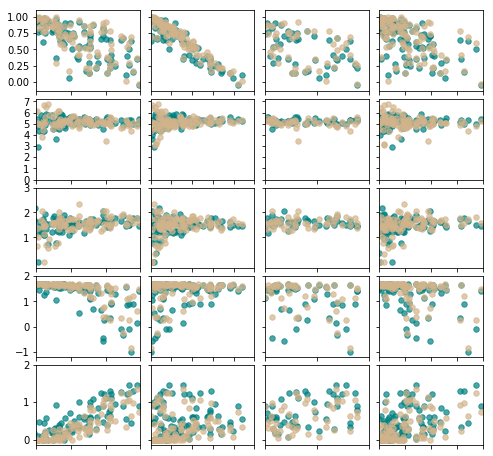

In [347]:
#plot global analysis and plot all as subplots
nx=len(short_varz_labels); ny=len(short_outz_labels);
fig,axarr=plt.subplots(ny,nx,sharey=False,sharex=False,
                       figsize=(8,8),
                       gridspec_kw={'wspace':0.1,'hspace':0.1})

for v in range(len(short_varz_labels)):
    for o in range(len(short_outz_labels)):  
        for iid in range(len(D)):
            g_out=analyze_out(list_tr_global[iid],tr_ctl)#analyze trial sims
            ax=axarr[o][v]
            ax.scatter(pltvarz[v,:],g_out[o],c=trialcolz[iid],s=30,alpha=0.7)
            ax.set_xlim([np.min(xtickz[v]),np.max(xtickz[v])])

            ax.set_yticks(ytickz[o]);  
            ax.set_xticks(xtickz[v])
            if v!=0:
                ax.set_yticklabels([])
            if o!=len(short_outz_labels):
                ax.set_xticklabels([])
            
labels_on=False
if labels_on:
    for v in range(len(short_varz_labels)):
        axarr[4][v].set_xlabel(short_varz_labels[v])
        
    for o in range(len(short_outz_labels)):  
        axarr[o][0].set_ylabel(short_outz_labels[o])

plt.savefig('figures/global/allcorrz.pdf',dpi=600)



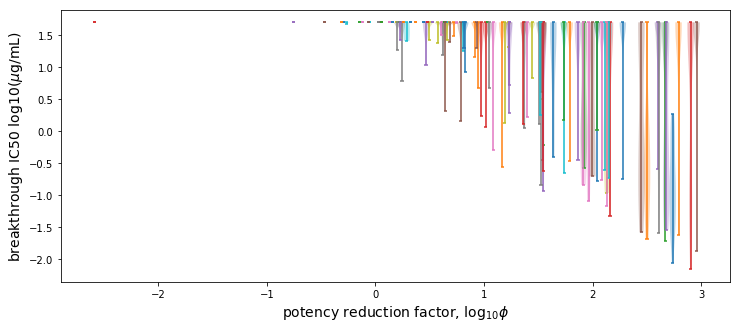

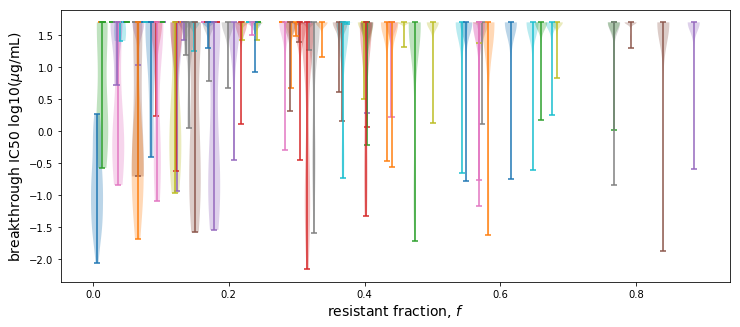

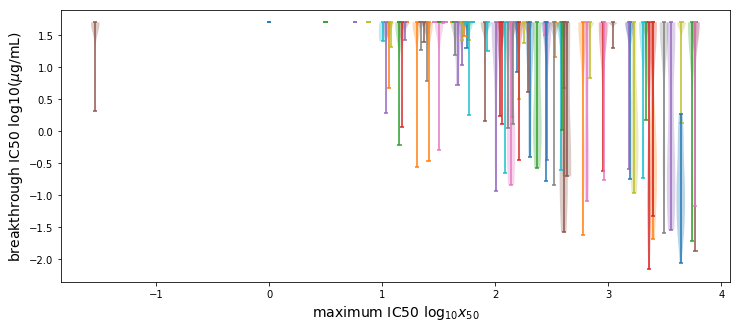

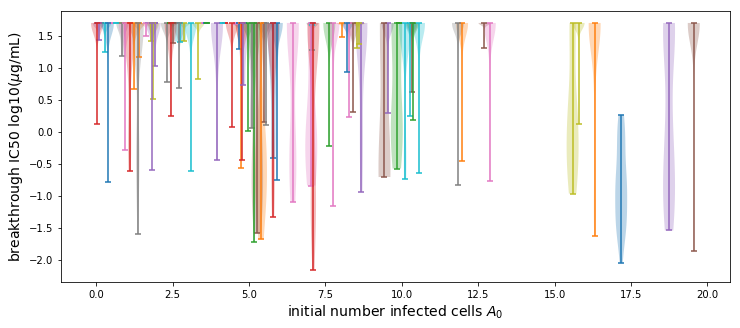

In [272]:
#density plot of breakthrough IC50s
for v in range(len(short_varz_labels)):
    plt.figure(figsize=(12,5))
    for iit in range(nts):    
        #for iid in range(len(D)):
        tr=list_tr_global[iid][iit]
        #rescale the IC50 so it matches what will be measured in vitro
        IC50s=np.log10(tr.ic50s[tr.fp_vs>0]/tr.iv_phi)
        IC50s[IC50s>np.log10(50)]=np.log10(50)

        if IC50s.size:
            plt.violinplot(IC50s,positions=[pltvarz[v][iit]],widths=max(pltvarz[v])/nts*2)
    plt.ylabel('breakthrough IC50 log10($\mu$g/mL)',fontsize=14)
    plt.xlabel(long_varz_labels[v],fontsize=14)
    plt.savefig('figures/global/violinIC50_'+str(v)+'outcome_'+str(o)+'.pdf',dpi=600)


In [259]:
#2 point correlation plots - skip redundant ones with "clever" for loop
if plot_all:
    for o in range(len(short_outz_labels)):
        for v1 in range(len(short_varz_labels)):
            for vx in range(len(short_varz_labels)-v1-1):
                v2=vx+v1+1
                plt.figure(figsize=(4,3))
                g_out=analyze_out(list_tr_global[iid],tr_ctl)#analyze trial sims
                plt.scatter(pltvarz[v1],pltvarz[v2],c=g_out[o],s=120)            

                plt.xlabel(short_varz_labels[v1],fontsize=12)
                plt.ylabel(short_varz_labels[v2],fontsize=12)

                plt.xlim([np.min(xtickz[v1]),np.max(xtickz[v1])])
                plt.ylim([np.min(xtickz[v2]),np.max(xtickz[v2])])

                plt.yticks(xtickz[v2])
                plt.xticks(xtickz[v1])

                #legend
                cbar = plt.colorbar()
                #cbar.ax.set_yticklabels(ytickz[o])
                plt.title(short_outz_labels[o])#cbar.set_label(short_outz_labels[o], rotation=270)

                plt.tight_layout()
                plt.savefig('figures/global/var_2pt_'+str(v1)+str(v2)+'outcome_'+str(o)+'.pdf',dpi=600)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


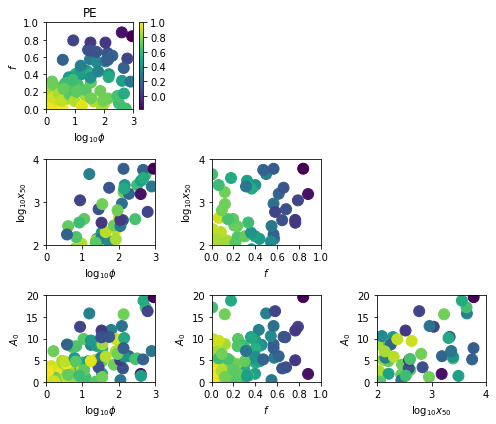

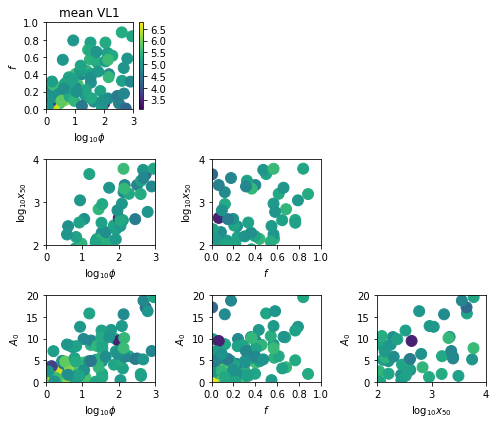

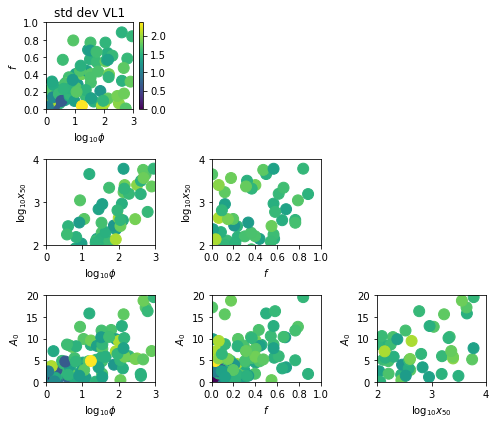

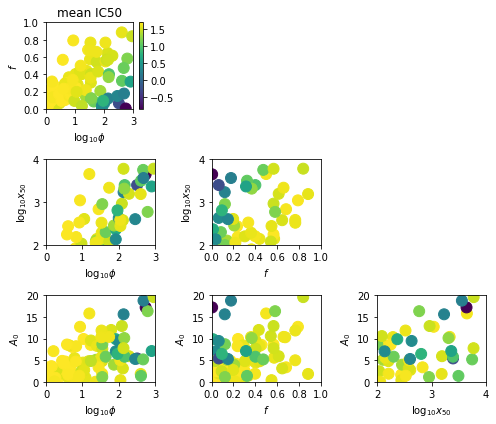

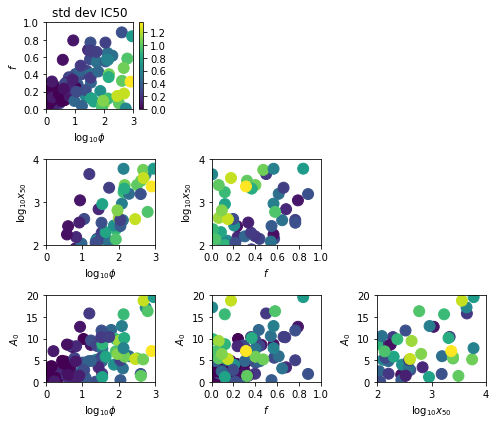

In [262]:
#2 point correlation plots - skip redundant ones with "clever" for loop
#as a an array of subplots!
vmatlist=[1,4,7,5,8,9]
for o in range(len(short_outz_labels)):
    plt.figure(figsize=(7,6))
    vind=1
    for v1 in range(len(short_varz_labels)):
        for vx in range(len(short_varz_labels)-v1-1):
            v2=vx+v1+1
            plt.subplot(3,3,vmatlist[vind-1])
            g_out=analyze_out(list_tr_global[iid],tr_ctl)#analyze trial sims
            plt.scatter(pltvarz[v1],pltvarz[v2],c=g_out[o],s=120)            

            plt.xlabel(short_varz_labels[v1],fontsize=10)
            plt.ylabel(short_varz_labels[v2],fontsize=10)

            plt.xlim([np.min(xtickz[v1]),np.max(xtickz[v1])])
            plt.ylim([np.min(xtickz[v2]),np.max(xtickz[v2])])

            plt.yticks(xtickz[v2])
            plt.xticks(xtickz[v1])

            vind+=1
    plt.subplot(331)
    plt.title(short_outz_labels[o])
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('figures/global/all2pts_out'+str(o)+'.pdf',dpi=600)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


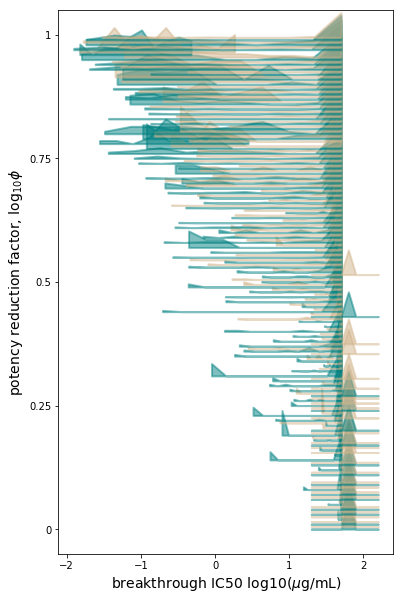

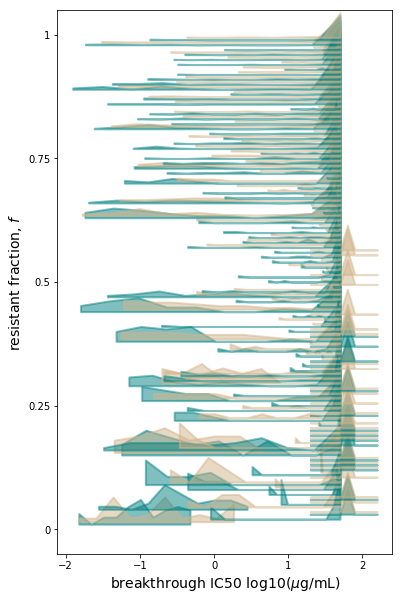

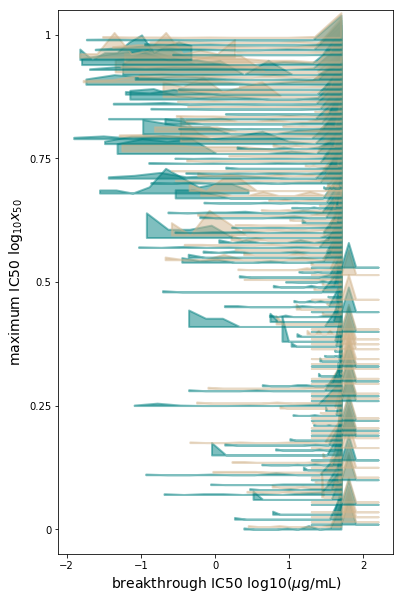

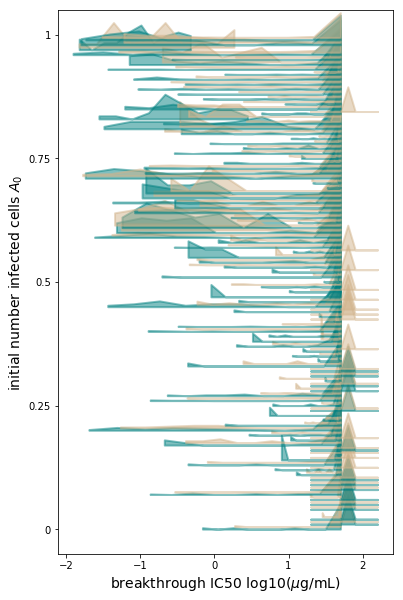

In [62]:
#density plot of breakthrough IC50s
for v in range(len(short_varz_labels)):
    plt.figure(figsize=(6,10))
    inds=np.argsort(pltvarz[v])
    yt=len(inds)/pindfac
    pind=0
    pindfac=5
    for iit in inds:    
        for iid in range(len(D)):
            tr=list_tr_global[iid][iit]
            #rescale the IC50 so it matches what will be measured in vitro
            IC50s=np.log10(tr.ic50s[tr.fp_vs>0]/tr.iv_phi)
            IC50s[IC50s>np.log10(50)]=np.log10(50)

            #plt.violinplot(IC50s,positions=[rf[it]],widths=0.1)
            hh=np.histogram(IC50s,bins=10)
            plt.fill_between(hh[1][1:],hh[0]/max(hh[0])+pind/pindfac,
                             np.ones(len(hh[1][1:]))*pind/pindfac,lw=2,alpha=0.5,color=trialcolz[iid])

            plt.ylim([-1,len(inds)/pindfac+1])

            pind+=1/2
    plt.xlabel('breakthrough IC50 log10($\mu$g/mL)',fontsize=14)
    plt.ylabel(long_varz_labels[v],fontsize=14)
    #plt.ylabel('fraction resistant (IC50>50$\mu$g/mL), $f$',fontsize=14)
    plt.yticks([0,yt/4,yt/2,yt*3/4,yt],[0,1/4,1/2,3/4,1])
    #plt.savefig('figures/gsense_density-rf.pdf',dpi=600)
    plt.savefig('figures/global/densityIC50_'+str(v)+'outcome_'+str(o)+'.pdf',dpi=600)


In [ ]:
#scatter plots of raw data showing correlations
colorz=['gray','navy','coral','skyblue']

ny=len(outnamez)
nx=len(varnamez)
fig,axarr=plt.subplots(ny,nx,sharey=False,sharex=False,
                       figsize=(9,8),
                       gridspec_kw={'wspace':0.1,'hspace':0.1})

#plt.figure(figsize=(8,8), gridspec_kw={'wspace':0.1,'hspace':0.1})
pind=0
for o in range(len(outcomes)):
    for v in range(len(varz)):
        ax=axarr[int(pind/nx)][pind%nx]
        #plt.subplot(5,4,pind)
        for iid in range(len(D)):
            g_out=analyze_out(list_tr_global[iid],tr_ctl)#analyze trial sims

            #plt.subplot(len(outcomes),len(varz),pind)
            #plt.scatter(outcomes[o]/np.nanstd(outcomes[o]),varz[v],color=colorz[v])

            yout=outcomes[o,ii,~np.isnan(outcomes[o,ii])]
            #yout=(yout-np.mean(yout))/np.std(yout)

            xout=varz[v,~np.isnan(outcomes[o,ii])]

            ax.scatter(xout,yout,color=trialcolz[ii],alpha=0.5)
            corrz=st.pearsonr(xout,yout)

            ax.set_xlim([min(xout),max(xout)])
            
            corrzlist[ii,v,o]=corrz[0]

            #plt.ylim([ytickz[o][0],ytickz[o][-1]])
            if pind%4!=0:
                ax.set_yticks(ytickz[o])
                ax.set_yticklabels([])
            else:
                ax.set_ylabel(outnamez[o],fontsize=10)
                ax.set_yticks(ytickz[o])
            
            if pind>15:
                ax.set_xlabel(varnamez[v])
                ax.set_xticks(xtickz[v])
            else:
                ax.set_xticks(xtickz[v])
                ax.set_xticklabels([])

            #plt.ylim([-3,3])
            #plt.title(r'$r^2=$' + str(np.round(corrz[0]**2,3))+pp,fontsize=10)
            #calculate correlation
        pind+=1

#plt.tight_layout()
plt.savefig('figures/gsense_corrplots.pdf',dpi=600)


In [ ]:
#scatter plots with all correlation coefficients
plt.figure(figsize=(10,4))
for ii in range(2):
    for v in range(len(varz)):

        plt.subplot(1,4,v+1)

        #plt.barh(corrzlist[ii,v,:],np.arange(len(outcomes)),color=trialcolz[ii])
        plt.scatter(corrzlist[ii,v,:],np.arange(len(outcomes))+ii/10,color=trialcolz[ii],s=30,marker='s')

        if v==0:
            plt.yticks(np.arange(len(outcomes)),outnamez)
        else:
            plt.yticks(np.arange(len(outcomes)),'')

        plt.ylim([-0.5,len(outcomes)-0.5])
        plt.xlim([-1.1,1.1])
        plt.title(varnamez[v])

        plt.axvline(-0.5,ls='--',color='gray',alpha=0.3)
        plt.axvline(0.5,ls='--',color='gray',alpha=0.3)
        plt.axvline(0,ls='-',color='gray',alpha=0.3)
        plt.xticks(np.linspace(-1,1,5))
        plt.xlabel('Pearson $r$')

plt.tight_layout()
plt.savefig('figures/gsense_pearsonVARS.pdf',dpi=600)


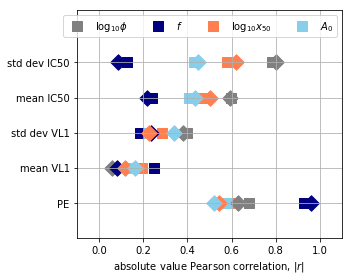

In [88]:
#scatter plot with all abs val correlation coefficients
colorz=['gray','navy','coral','skyblue']
plt.figure(figsize=(5,4))
markz=['s','D']
for iid in range(len(D)):
    for v in range(len(short_varz_labels)):
        plt.scatter(np.abs(corrzlist[iid,v,:]),range(len(short_outz_labels)),
                    color=colorz[v],s=120,marker=markz[iid])
        
plt.yticks(np.arange(len(short_outz_labels)),short_outz_labels)
plt.ylim([-1,len(short_outz_labels)+0.5])
plt.xlim([-0.1,1.1])

#plt.axvline(-0.5,ls='--',color='k')
#plt.axvline(0.5,ls='--',color='k')
plt.xlabel('absolute value Pearson correlation, $|r|$')
plt.grid()
plt.legend(short_varz_labels,ncol=4)
plt.tight_layout()
plt.savefig('figures/gsense_pearsonALL.pdf',dpi=600)


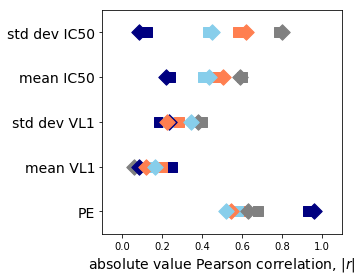

In [270]:
#scatter plot with all abs val correlation coefficients - no legend
plt.figure(figsize=(5,4))
for iid in range(len(D)):
    for v in range(len(short_varz_labels)):
        plt.scatter(np.abs(corrzlist[iid,v,:]),range(len(short_outz_labels)),
                    color=colorz[v],s=120,marker=markz[iid])
        
plt.yticks(np.arange(len(short_outz_labels)),short_outz_labels,fontsize=14)
plt.ylim([-0.5,len(short_outz_labels)-0.5])
plt.xlim([-0.1,1.1])
plt.xlabel('absolute value Pearson correlation, $|r|$',fontsize=14)
plt.tight_layout()
plt.savefig('figures/gsense_pearsonALL2.pdf',dpi=600)




In [ ]:
#show how much the delay effect varies across global sensitivity analysis?

#have to figure out if detected interval represents real exposure interval

#check the calculation
print('exposure week:',np.floor(tr_ctl.ex_ts[:10]/7))
print('exposure interval (1st or 2nd):',1+np.floor(tr_ctl.ex_ts[:10]/7/4)%2)

#make the matrix of exposures > detections
def calc_brksmat(tr):
    exts=1+np.floor(tr.ex_ts[tr.fp_ts>0]/7/4)%2
    fpts=1+np.floor(tr.fp_ts[tr.fp_ts>0]/7/4)%2
    brksmat=np.zeros([2,2])
    for i in range(len(exts)):    
        if exts[i]==1 and fpts[i]==1:
            brksmat[0,0]+=1 #exp 1, det 1
        if exts[i]==1 and fpts[i]==2:
            brksmat[0,1]+=1 #exp 1, det 2
        if exts[i]==2 and fpts[i]==1:
            brksmat[1,0]+=1 #exp 2, det next 1
        if exts[i]==2 and fpts[i]==2:
            brksmat[1,1]+=1 #exp 2, det 2

    return brksmat

#calculate for all trials
obstrue=np.zeros([nts])
obsfalse=np.zeros([nts])
for it in range(nts):    
    tr=tr10[it]

    brksmat=calc_brksmat(tr)
    
    obstrue[it]=(brksmat[0,0]+brksmat[1,1])/np.sum(brksmat)
    obsfalse[it]=(brksmat[0,1]+brksmat[1,0])/np.sum(brksmat)
    
goodind=~np.isnan(obstrue)
obstrue=obstrue[goodind]
obsfalse=obsfalse[goodind]

plt.figure(figsize=(7,3))

plt.subplot(121)
plt.scatter(iv[goodind],obstrue,color='steelblue')
plt.scatter(iv[goodind],obsfalse,color='purple')
plt.semilogx()
plt.xlabel(varnamez[0])
plt.ylabel('fraction')
plt.legend(['obs=exp',r'obs$\ne$exp'])

plt.subplot(122)
plt.scatter(rf[goodind],obstrue,color='steelblue')
plt.scatter(rf[goodind],obsfalse,color='purple')
plt.xlabel(varnamez[1])

plt.tight_layout()
plt.savefig('figures/gsense_delays1.pdf',dpi=600)

#visualize another way
plt.figure(figsize=(4,3))
plt.boxplot([obstrue,obsfalse],positions=[1,2],widths=0.7)#,color='k')
plt.scatter(np.random.normal(1,0.1,len(obstrue)),obstrue,color='steelblue')
plt.scatter(np.random.normal(2,0.1,len(obsfalse)),obsfalse,color='purple')
#plt.grid()
plt.xticks([1,2],['obs=exp',r'obs$\ne$exp'])
plt.ylabel('fraction across 100 \n global sensitivity analyses')
plt.yticks(np.linspace(0,1,11))
plt.ylim()
plt.tight_layout()

plt.savefig('figures/gsense_delays2.pdf',dpi=600)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.

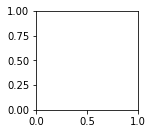

In [373]:
#check on the accuracy of the regression (predictability?)
num_train=75
num_test=20

x=np.arange(nts)
np.random.shuffle(x)
xs=list(x) #make a shuffled list of indicies

tot_errz=np.zeros([len(D),len(short_varz_labels),num_test])
rel_errz=np.zeros([len(D),len(short_varz_labels),num_test])

plt.figure(figsize=(4,4))
for iid in range(len(D)):
    g_out=analyze_out(list_tr_global[iid],tr_ctl)#analyze trial sims
    g_out[np.isnan(g_out)]=0 #not too many of these, hopefully doesn't mess it up too much
    
    #loop over each sensitivity analysis variable, and see if (or how well) we can infer it
    for v in range(len(short_varz_labels)):    
        
        reg = slm.LinearRegression() #define a regression object #reg.set_params(normalize=True)
        reg.fit(g_out.T[xs[:num_train]],pltvarz[v,xs[:num_train]]) #fit on rtaining set

        plt.subplot(221+v)
        true=pltvarz[v,xs[num_train:num_test+num_train]]
        test=reg.predict(g_out.T[xs[num_train:num_test+num_train]])
        
        plt.scatter(true,test,lw=0,color=trialcolz[iid],s=80,alpha=0.5)
        
        #calculate error
        tot_errz[iid,v,:]=true-test
        
        if v==0 or v==2:
            rel_errz[iid,v,:]=np.abs(10**true-10**test)/10**true*100
        if v==1 or v==3:
            rel_errz[iid,v,:]=np.abs(true-test)/true*100
        
        plt.ylabel(short_varz_labels[v]+' predicted')
        plt.xlabel(short_varz_labels[v]+' true')

        #plt.xlim([np.min(xtickz[v]),np.max(xtickz[v])])
        #plt.ylim([np.min(xtickz[v]),np.max(xtickz[v])])

        plt.yticks(xtickz[v]);plt.xticks(xtickz[v])
        #plt.locator_params(nbins=4)

plt.tight_layout()
plt.savefig('figures/gsense_pred1.pdf',dpi=600)
    

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


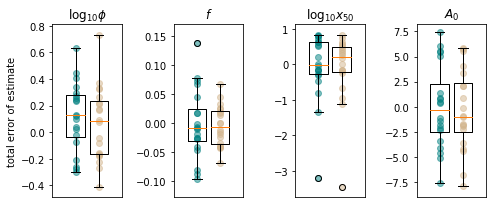

In [223]:
#plot total errors
plt.figure(figsize=(7,3))
for iid in range(len(D)):
    for v in range(len(short_varz_labels)):    
        plt.subplot(141+v)
        plt.scatter(np.ones(num_test)+iid/2,tot_errz[iid,v,:],color=trialcolz[iid],alpha=0.5)
        plt.boxplot(tot_errz[iid,v,:],positions=[1+iid/2],widths=0.4)    

        plt.title(short_varz_labels[v])
        if v==0:
            plt.ylabel('total error of estimate')
        plt.xticks([])
        
        plt.xlim([0.5,2])
        #plt.xticks(range(len(short_varz_labels)),short_varz_labels)

plt.tight_layout()
plt.savefig('figures/gsense_pred2.pdf')


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


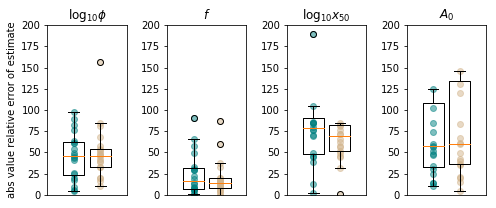

In [224]:
#plot percemt errors
plt.figure(figsize=(7,3))
for iid in range(len(D)):
    for v in range(len(short_varz_labels)):    
        plt.subplot(141+v)
        plt.scatter(np.ones(num_test)+iid/2,rel_errz[iid,v,:],color=trialcolz[iid],alpha=0.5)
        plt.boxplot(rel_errz[iid,v,:],positions=[1+iid/2],widths=0.4)    

        plt.title(short_varz_labels[v])
        if v==0:
            plt.ylabel('abs value relative error of estimate')
        plt.xticks([])
        
        plt.xlim([0.5,2])
        plt.ylim([0,200])
        #plt.xticks(range(len(short_varz_labels)),short_varz_labels)

plt.tight_layout()
plt.savefig('figures/gsense_pred3.pdf')


In [267]:
#2 point correlation plots THE OTHER WAY
if plot_all:
    for v in range(len(short_varz_labels)):
        for o1 in range(len(short_outz_labels)):
            for ox in range(len(short_outz_labels)-o1-1):
                o2=ox+o1+1
                #print(o1,o2)            
                plt.figure(figsize=(4,3))
                g_out=analyze_out(list_tr_global[iid],tr_ctl)#analyze trial sims
                plt.scatter(g_out[o1],g_out[o2],c=pltvarz[v],s=120)            

                plt.xlabel(short_outz_labels[o1],fontsize=12)
                plt.ylabel(short_outz_labels[o2],fontsize=12)

                plt.xlim([np.min(ytickz[o1]),np.max(ytickz[o1])])
                plt.ylim([np.min(ytickz[o2]),np.max(ytickz[o2])])

                plt.xticks(ytickz[o1]); plt.yticks(ytickz[o2]); 

                #legend
                cbar = plt.colorbar()
                #cbar.ax.set_ylim([np.min(xtickz[v]),np.max(xtickz[v])])
                #cbar.ax.set_yticklabels(xtickz[v])
                plt.title(short_varz_labels[v])#cbar.set_label(short_outz_labels[o], rotation=270)

                plt.tight_layout()
                plt.savefig('figures/global/out_2pt_'+str(o1)+str(o2)+'var_'+str(v)+'.pdf',dpi=600)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


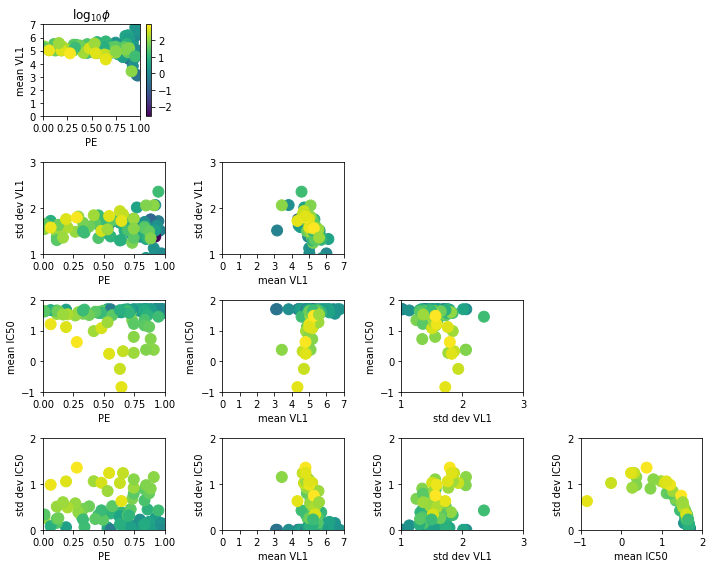

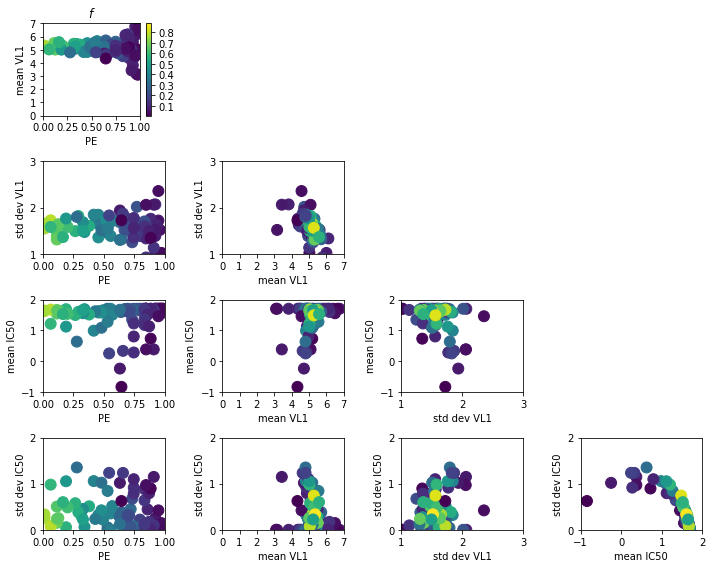

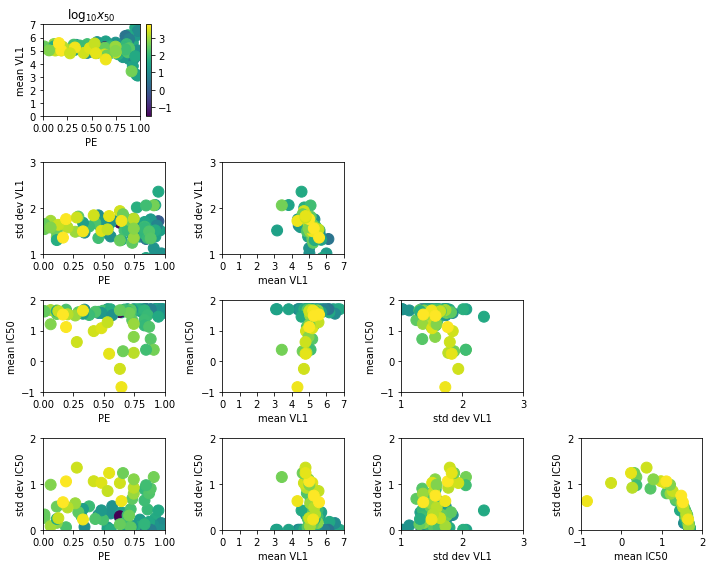

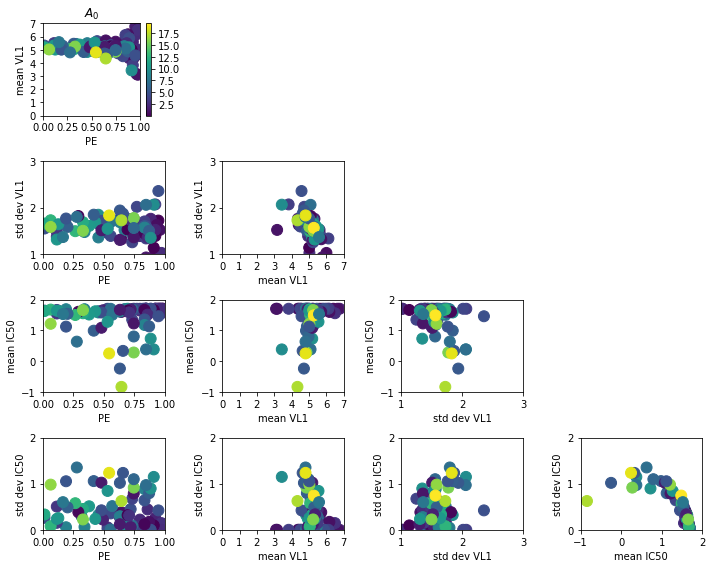

In [266]:
#THE OTHER WAY
#2 point correlation plots - skip redundant ones with "clever" for loop
#as a an array of subplots!
omatlist=[1,5,9,13,6,10,14,11,15,16]
for v in range(len(short_varz_labels)):
    plt.figure(figsize=(10,8))
    oind=1
    for o1 in range(len(short_outz_labels)):
        for ox in range(len(short_outz_labels)-o1-1):
            o2=ox+o1+1
            plt.subplot(4,4,omatlist[oind-1])
            g_out=analyze_out(list_tr_global[iid],tr_ctl)#analyze trial sims
            plt.scatter(g_out[o1],g_out[o2],c=pltvarz[v],s=120)            

            plt.xlabel(short_outz_labels[o1],fontsize=10)
            plt.ylabel(short_outz_labels[o2],fontsize=10)

            plt.xlim([np.min(ytickz[o1]),np.max(ytickz[o1])])
            plt.ylim([np.min(ytickz[o2]),np.max(ytickz[o2])])

            plt.xticks(ytickz[o1]); plt.yticks(ytickz[o2]); 
            oind+=1

    plt.subplot(441)
    plt.title(short_varz_labels[v])
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('figures/global/all2pts_infer'+str(v)+'.pdf',dpi=600)



In [331]:
#loop to make heatmaps for f and phi

nts=10 #number of trials
Nps=100 #number of exposures per trial

iv=np.logspace(0,3,nts) #potency factor
rf=np.linspace(0.10,1,nts) #resistant fraction, never less than 10%

%time tr_ctl=AMPmodule.trial(name='ctl', nps=Nps, tF=560, dose=0, clade='bimodal', rfrac=0.1, A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)

dose=10
list_tr2=[];
for iit1 in range(nts):
    for iit2 in range(nts):
        l2_out = AMPmodule.trial(name='D_'+str(dose)+'_'+str(iit2), nps=Nps, tF=560, 
                           dose=dose, clade='bimodal', 
                           rfrac=rf[iit1], A0=1, iv_phi=iv[iit2], maxIC50=100, 
                               v_flg=False, keep_flg=0)
        list_tr2.append(l2_out)
    print(iit1)
gog=analyze_out(list_tr2,tr_ctl)#analyze trial sims

CPU times: user 54.8 s, sys: 561 ms, total: 55.4 s
Wall time: 55 s
0
1
2
3
4
5
6
7
8
9


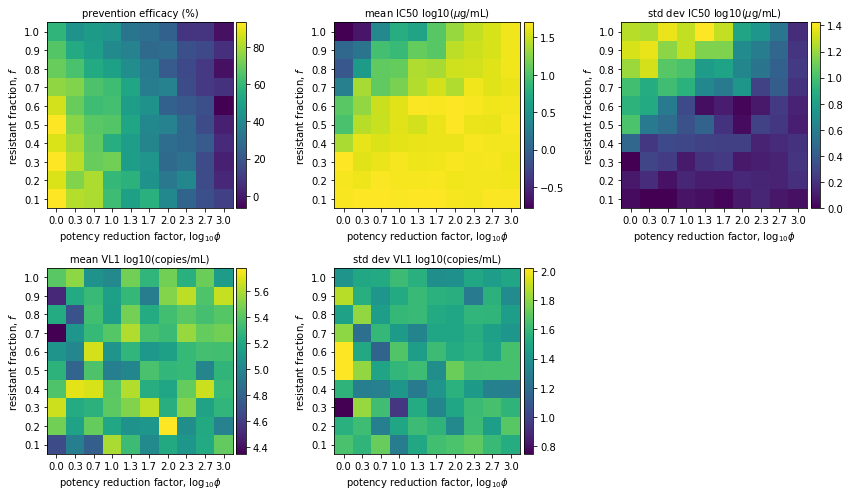

In [370]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

long_outz_labels=['prevention efficacy (%)',
                  'mean VL1 log10(copies/mL)',
                  'std dev VL1 log10(copies/mL)',
                  'mean IC50 log10($\mu$g/mL)',
                  'std dev IC50 log10($\mu$g/mL)']

#loop through and make heatmaps
plt.figure(figsize=(12,7))
oi=[1,4,5,2,3]
for o in range(len(short_outz_labels)):
    plt.subplot(2,3,oi[o])
    pout=np.zeros([nts,nts])
    for iit1 in range(nts):
        for iit2 in range(nts):

            if o==0:
                cc=100
            else:
                cc=1
            pout[iit2,iit1]=cc*gog[o,iit2+nts*iit1]
    im=plt.imshow(pout,origin='lower')#,interpolation='gaussian')#vmin=min(ytickz[o]),vmax=max(ytickz[o]))
    plt.xticks(range(nts),np.round(np.log10(iv),1),fontsize=10)
    plt.yticks(range(nts),np.round(rf,1),fontsize=10)
    plt.xlabel(long_varz_labels[0])
    plt.ylabel(long_varz_labels[1])
    plt.title(long_outz_labels[o],fontsize=10)
    
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cb=plt.colorbar(im, cax=cax)
    #cb.ax.set_ylabel(long_outz_labels[o],fontsize=10)

plt.tight_layout()
plt.savefig('figures/global/heatmaps.pdf',dpi=600)
